Rank categories: ['Top 10' 'Top 100' 'Top 200' 'Top 50']
Epoch 1/50, Loss: 0.993993, Accuracy: 0.5837
Epoch 2/50, Loss: 0.718017, Accuracy: 0.6864
Epoch 3/50, Loss: 0.641339, Accuracy: 0.7099
Epoch 4/50, Loss: 0.630908, Accuracy: 0.7146
Epoch 5/50, Loss: 0.612082, Accuracy: 0.7195
Epoch 6/50, Loss: 0.606361, Accuracy: 0.7226
Epoch 7/50, Loss: 0.596259, Accuracy: 0.7260
Epoch 8/50, Loss: 0.593302, Accuracy: 0.7265
Epoch 9/50, Loss: 0.595181, Accuracy: 0.7253
Epoch 10/50, Loss: 0.586961, Accuracy: 0.7271
Epoch 11/50, Loss: 0.580953, Accuracy: 0.7291
Epoch 12/50, Loss: 0.580729, Accuracy: 0.7309
Epoch 13/50, Loss: 0.579517, Accuracy: 0.7311
Epoch 14/50, Loss: 0.577488, Accuracy: 0.7292
Epoch 15/50, Loss: 0.580561, Accuracy: 0.7292
Epoch 16/50, Loss: 0.575439, Accuracy: 0.7301
Epoch 17/50, Loss: 0.573552, Accuracy: 0.7331
Epoch 18/50, Loss: 0.571004, Accuracy: 0.7330
Epoch 19/50, Loss: 0.571493, Accuracy: 0.7316
Epoch 20/50, Loss: 0.572569, Accuracy: 0.7323
Epoch 21/50, Loss: 0.571449, Acc

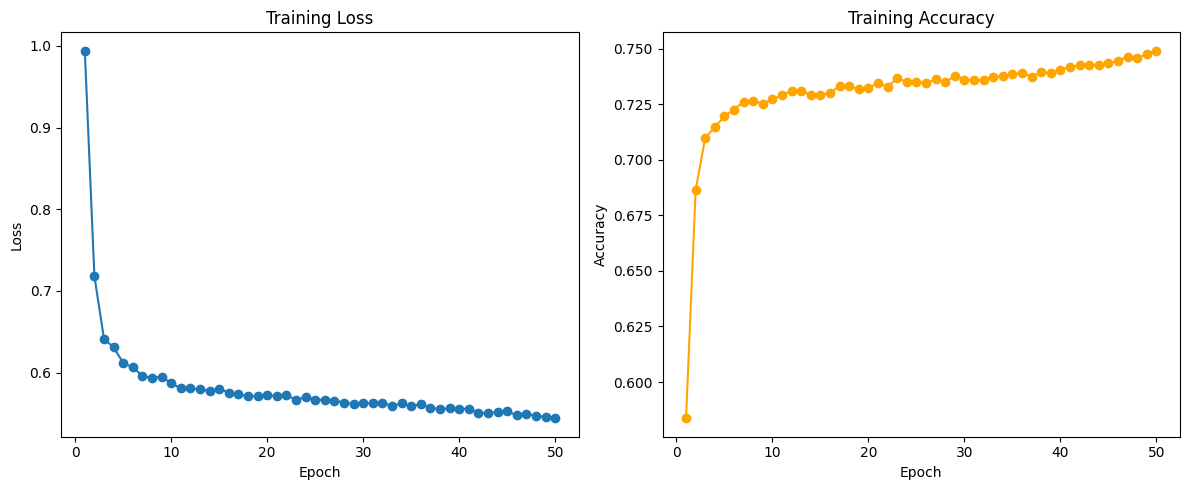

Test Accuracy: 0.7956
预测步数（月数差）： 9
类别映射 (encoded: avg normalized Hours_streamed): {0: 0.17311983857920024, 1: 0.008623559767100096, 2: 0.003302411410034473, 3: 0.030422045731353993}
预测未来 2025.6 的 Rank: Top 200


/Users/wuchenghao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [1]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

df = pd.read_csv("data.csv")

df = df.sort_values(by=["Year", "Month"]).reset_index(drop=True)

label_encoder = LabelEncoder()
df["rank_category_encoded"] = label_encoder.fit_transform(df["rank_category"])
num_classes = len(label_encoder.classes_)
print("Rank categories:", label_encoder.classes_)
data_feature = df[["Hours_streamed"]].values.astype(float)
data_target = df["rank_category_encoded"].values

scaler = MinMaxScaler(feature_range=(0, 1))
data_feature_scaled = scaler.fit_transform(data_feature)

def create_sequences(features, labels, seq_length):
    sequences, targets = [], []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i+seq_length])
        targets.append(labels[i+seq_length])
    return np.array(sequences), np.array(targets)

seq_length = 12
X, y = create_sequences(data_feature_scaled, data_target, seq_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class LSTMClassifier(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, num_classes=4):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(input_size=1, hidden_size=50, num_layers=2, num_classes=num_classes).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}, Accuracy: {epoch_accuracy:.4f}')

# 绘制训练曲线
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, marker='o', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

# -----------------------------
# 4. 测试集评估
# -----------------------------
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total_test += batch_y.size(0)
        correct_test += (predicted == batch_y).sum().item()

test_accuracy = correct_test / total_test
print("Test Accuracy: {:.4f}".format(test_accuracy))

# -----------------------------
# 5. 利用训练好的模型预测未来某月的 Rank
# -----------------------------
# 目标月份（例如预测 2025 年 6 月的 Rank）
target_year = 2025
target_month = 6

# 获取历史数据最后一条记录的年份和月份（假设历史数据中的最后一行为最新记录）
last_year = df['Year'].iloc[-1]
last_month = df['Month'].iloc[-1]
# 计算从最后记录到目标月份的月份差
months_diff = (target_year - last_year) * 12 + (target_month - last_month)
print("预测步数（月数差）：", months_diff)

# 构造类别映射：
# 利用归一化后的 Hours_watched 计算每个类别的平均值，作为该类别的代表归一化值
df['Hours_streamed_norm'] = scaler.transform(df[['Hours_streamed']])
category_mapping = {}
for cat in np.unique(df['rank_category_encoded']):
    avg_norm = df[df['rank_category_encoded'] == cat]['Hours_streamed_norm'].mean()
    category_mapping[cat] = avg_norm
print("类别映射 (encoded: avg normalized Hours_streamed):", category_mapping)

# 从构造的序列 X 中取最后一个序列作为初始输入，形状为 (1, seq_length, 1)
last_sequence = X[-1]
last_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

predicted_rank = None  # 用于存储最新预测类别

# 迭代预测 months_diff 步，模拟每个月的预测
for _ in range(months_diff):
    with torch.no_grad():
        outputs = model(last_sequence)
        _, predicted = torch.max(outputs.data, 1)
        predicted_rank = predicted.item()
    # 利用类别映射获得该类别对应的平均归一化值
    predicted_norm_value = category_mapping[predicted_rank]
    # 构造形状 (1, 1, 1) 的张量作为新的预测值
    predicted_tensor = torch.tensor([[[predicted_norm_value]]], dtype=torch.float32).to(device)
    # 将序列向前滚动一位，并将最新预测值附加到序列末尾
    last_sequence = torch.cat((last_sequence[:, 1:, :], predicted_tensor), dim=1)

# 将预测类别转换回原始标签
predicted_rank_label = label_encoder.inverse_transform([predicted_rank])[0]
print(f"预测未来 {target_year}.{target_month} 的 Rank: {predicted_rank_label}")


In [2]:
from sklearn.metrics import r2_score, mean_squared_error

# Calculate predictions for training data
model.eval()
train_preds, train_true = [], []
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.cpu().numpy()
        train_preds.extend(preds)
        train_true.extend(y_batch.numpy())

# Calculate predictions for test data
test_preds, test_true = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.cpu().numpy()
        test_preds.extend(preds)
        test_true.extend(y_batch.numpy())

# Convert lists to numpy arrays
train_preds, train_true = np.array(train_preds), np.array(train_true)
test_preds, test_true = np.array(test_preds), np.array(test_true)

# Calculate R^2 and RMSE for training
r2_train = r2_score(train_true, train_preds.argmax(axis=1))
rmse_train = mean_squared_error(train_true, train_preds.argmax(axis=1), squared=False)

# Calculate R^2 and RMSE for testing
r2_test = r2_score(test_true, test_preds.argmax(axis=1))
rmse_test = mean_squared_error(test_true, test_preds.argmax(axis=1), squared=False)

print(f'Training R²: {r2_train:.4f}, Training RMSE: {rmse_train:.4f}')
print(f'Testing R²: {r2_test:.4f}, Testing RMSE: {rmse_test:.4f}')


Training R²: 0.2907, Training RMSE: 0.6664
Testing R²: 0.0288, Testing RMSE: 0.7798


Confusion Matrix:
[[ 188    0   20    0]
 [   7  401  110  532]
 [   2  142 1922   34]
 [   0   11    0  829]]


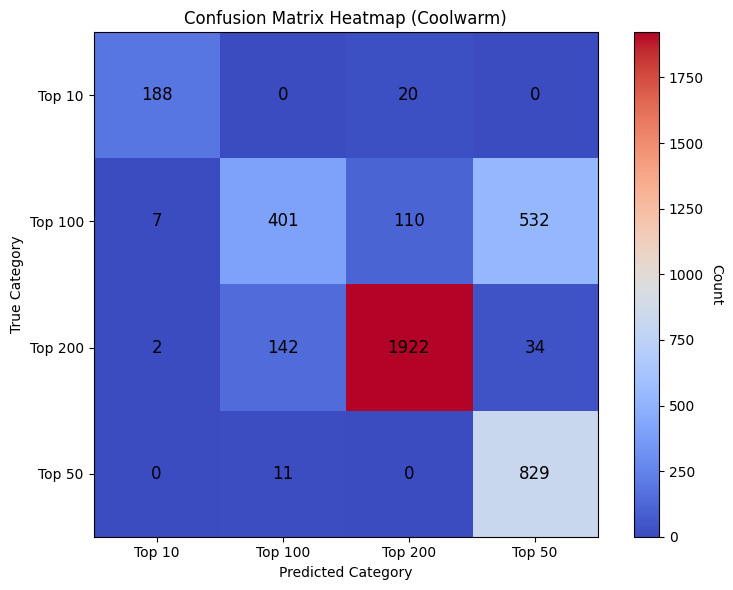

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 预测测试集所有数据
model.eval()
all_true = []
all_pred = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        all_true.extend(batch_y.cpu().numpy())
        all_pred.extend(predicted.cpu().numpy())

# 计算混淆矩阵
cm = confusion_matrix(all_true, all_pred)
print("Confusion Matrix:")
print(cm)

# 定义类别标签
categories = label_encoder.inverse_transform(np.arange(num_classes))

# 使用 matplotlib 绘制热力图，采用 coolwarm 配色方案
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap="coolwarm")

# 添加颜色条
cbar = plt.colorbar(im)
cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")

# 设置 x、y 轴刻度和标签
ax.set_xticks(np.arange(len(categories)))
ax.set_yticks(np.arange(len(categories)))
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)

# 标注每个单元格的数值
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"), ha="center", va="center", color="black", fontsize=12)

ax.set_xlabel("Predicted Category")
ax.set_ylabel("True Category")
ax.set_title("Confusion Matrix Heatmap (Coolwarm)")
plt.tight_layout()
plt.show()


         precision    recall  f1-score  support
Top 10    0.954315  0.903846  0.928395    208.0
Top 100   0.723827  0.381905  0.500000   1050.0
Top 200   0.936647  0.915238  0.925819   2100.0
Top 50    0.594265  0.986905  0.741834    840.0


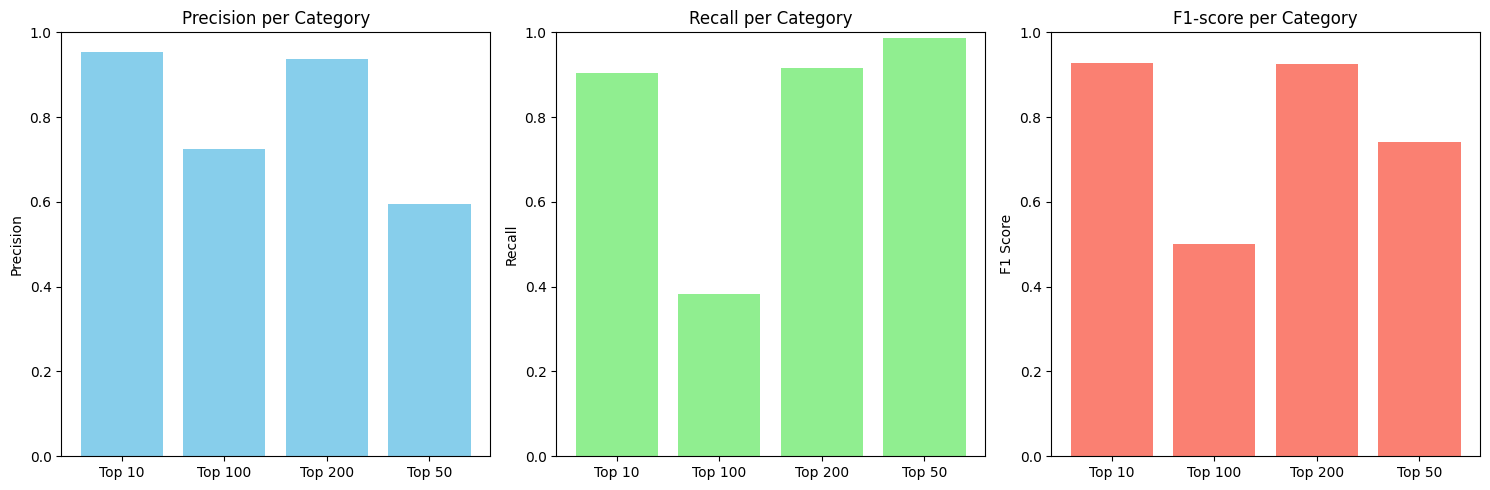

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# 计算分类报告，输出为字典格式
report_dict = classification_report(all_true, all_pred, target_names=categories, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
# 只保留各类别的指标（排除 'accuracy', 'macro avg', 'weighted avg'）
report_df = report_df.loc[categories]
print(report_df)

# 绘制 Precision, Recall, F1-score 的条形图
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Precision
ax[0].bar(report_df.index, report_df['precision'], color='skyblue')
ax[0].set_title('Precision per Category')
ax[0].set_ylim(0, 1)
ax[0].set_ylabel('Precision')

# Recall
ax[1].bar(report_df.index, report_df['recall'], color='lightgreen')
ax[1].set_title('Recall per Category')
ax[1].set_ylim(0, 1)
ax[1].set_ylabel('Recall')

# F1-score
ax[2].bar(report_df.index, report_df['f1-score'], color='salmon')
ax[2].set_title('F1-score per Category')
ax[2].set_ylim(0, 1)
ax[2].set_ylabel('F1 Score')

plt.tight_layout()
plt.show()


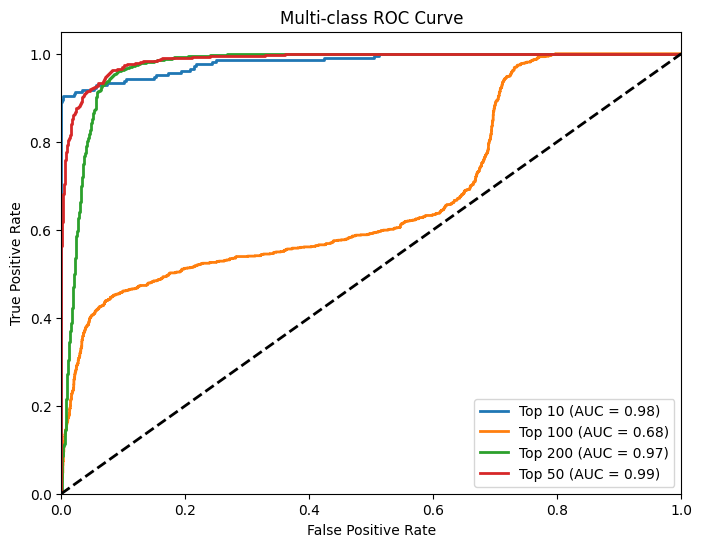

In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 预测测试集所有数据，获得每个类别的概率输出
model.eval()
all_true = []
all_prob = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        prob = F.softmax(outputs, dim=1)  # 转换为概率
        all_true.extend(batch_y.cpu().numpy())
        all_prob.append(prob.cpu().numpy())

all_prob = np.concatenate(all_prob, axis=0)
all_true = np.array(all_true)

# 对真实标签进行二值化处理，方便计算每个类别的 ROC 曲线
all_true_binarized = label_binarize(all_true, classes=np.arange(num_classes))

# 计算每个类别的 FPR, TPR 以及 AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_true_binarized[:, i], all_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制每个类别的 ROC 曲线
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()
